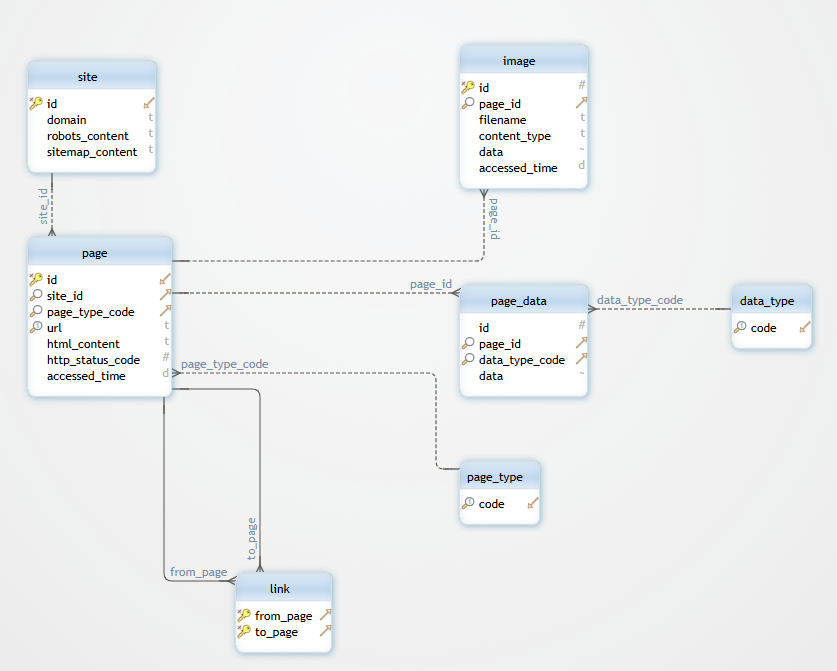

HTTP downloader and renderer: To retrieve and render a web page.

Data extractor: Minimal functionalities to extract images and hyperlinks.

Duplicate detector: To detect already parsed pages.

URL frontier: A list of URLs waiting to be parsed.

Datastore: To store the data and additional metadata used by the crawler.

In your implementation you must set the User-Agent field of your bot to fri-wier-NAME_OF_YOUR_GROUP.



In [ ]:
import os
import time
import hashlib
import requests
import dotenv
from urllib.parse import urljoin, urlparse, urlsplit
from urllib.robotparser import RobotFileParser
from bs4 import BeautifulSoup
from threading import Thread, Lock
import heapq
from queue import Queue
from datetime import datetime
from Connection import PostgresDB as BabaVangaDB
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import random
import hashlib
# Configure Selenium WebDriver (Headless Chrome)
chrome_options = Options()
chrome_options.add_argument("--headless")
chrome_options.add_argument("--disable-gpu")
chrome_options.add_argument("--no-sandbox")

dotenv.load_dotenv()
db_name = os.getenv("DB_NAME")
db_user = os.getenv("DB_USER")
db_password = os.getenv("DB_PASSWORD")
db_host = os.getenv("DB_HOST")
db_port = os.getenv("DB_PORT")

db = BabaVangaDB(db_name, db_user, db_password, db_host, db_port)
db.connect()
domain = "https://med.over.net/"

Connected to: PostgreSQL 17.4 on x86_64-windows, compiled by msvc-19.42.34436, 64-bit


In [ ]:
import requests
from mimetypes import guess_extension, guess_type
from urllib.parse import urljoin
import re

class SpiderMonkey:
    def __init__(self, domain, max_workers=4, max_pages=5000):
        self.domain = domain
        self.keyword = "kajenje pomaga zdravju"
        self.robots_content = None
        self.sitemap_content = None
        self.site_id = None
        self.visited_urls = set()
        self.page_hashes = set()
        self.url_queue = []
        heapq.heappush(self.url_queue, (0, domain))
        self.lock = Lock()
        self.max_pages = max_pages
        self.page_count = 0
        self.init_db()
    
    def init_db(self):
        self.db = BabaVangaDB(db_name, db_user, db_password, db_host, db_port)
        self.db.connect()

    def in_domain(self, url):
        return url.startswith(self.domain)

    def can_crawl(self, url):
        robots_url = urljoin(url, "/robots.txt")
        rp = RobotFileParser()
        
        try:
            rp.set_url(robots_url)
            rp.read()
            self.robots_content = requests.get(robots_url, timeout=5).text
            #return True
            return rp.can_fetch("*", url)

        except Exception as e:
            print("Error checking robots.txt:", e)
            return False  # Default to no crawling if there's an issue
    
    def get_sitemap_urls(self, sitemap_url):
        try:
            response = requests.get(sitemap_url, timeout=2)
            print("Sitemap response status:", response.status_code)
            if response.status_code == 200:
                soup = BeautifulSoup(response.content, "xml")
                self.sitemap_content = soup
                urls = [url.loc.text for url in soup.find_all("loc")]
                return urls
        except Exception as e:
            print("Error fetching sitemap:", e)
        return []
    
    def extract_links(self, html, base_url):
        """Extracts and returns all links from the HTML content, including JavaScript onclick links."""
        
        soup = BeautifulSoup(html, "html.parser")
        links = []

        # Extract from <a> tags
        for a_tag in soup.find_all("a", href=True):
            href = a_tag["href"].strip()
            
            # Handle different types of links
            if href.startswith("http"):
                full_url = href
            elif href.startswith("//"):
                full_url = "https:" + href
            elif href.startswith("/"):
                full_url = urljoin(base_url, href)
            else:
                full_url = urljoin(base_url, href)

            links.append((full_url, a_tag))

        # Extract from onclick attributes (JavaScript-based links)
        for tag in soup.find_all(onclick=True):
            onclick_text = tag["onclick"]
            match = re.search(r"location\.href\s*=\s*[\"'](.*?)[\"']", onclick_text)
            if match:
                js_href = match.group(1)
                if js_href.startswith("http"):
                    full_url = js_href
                elif js_href.startswith("//"):
                    full_url = "https:" + js_href
                elif js_href.startswith("/"):
                    full_url = urljoin(base_url, js_href)
                else:
                    full_url = urljoin(base_url, js_href)

                links.append((full_url, tag))

        return links

    def extract_images(self, html_content, base_url):
        """
        Extracts image URLs from an HTML page and downloads the image data.
        
        :param html_content: The HTML source of the web page.
        :param base_url: The base URL of the website (to resolve relative links).
        :return: List of tuples (filename, content_type, image_data).
        """
        soup = BeautifulSoup(html_content, "html.parser")
        images = []

        for img_tag in soup.find_all('img', src=True):
            img_url = urljoin(base_url, img_tag['src'])  # Handle relative URLs

            try:
                response = requests.get(img_url, timeout=5)  # Fetch image
                if response.status_code == 200:
                    content_type = response.headers.get("Content-Type", "unknown")
                    ext = guess_extension(content_type) or ".jpg"
                    filename = img_url.split("/")[-1] if "." in img_url.split("/")[-1] else f"image{ext}"
                    image_data = response.content

                    images.append((filename, content_type, image_data))
            except Exception as e:
                print(f"Failed to fetch image {img_url}: {e}")

        return images

    # MinHash function to create signatures for sets
    @staticmethod
    def minhash(set_of_words, num_hashes=200):
        hashes = []
        for i in range(num_hashes):
            seed = random.randint(0, 2**32 - 1)
            min_hash_value = min(hash(f"{hash(seed)}:{word}") for word in set_of_words)
            hashes.append(min_hash_value)
        return hashes

    # Jaccard Similarity computation
    @staticmethod
    def jaccard_similarity(set1, set2):
        intersection = len(set1.intersection(set2))
        union = len(set1.union(set2))
        return intersection / union

    # Function to detect duplicate based on Jaccard similarity
    def is_duplicate_using_jaccard(self, html_content, threshold=0.8):
        set_of_words = set(html_content.split())  # This will split by whitespace; more advanced tokenization can be used
        signature = self.minhash(set_of_words)

        # Compare against previously stored signatures
        for stored_signature in self.signatures:
            similarity = self.jaccard_similarity(set(signature), set(stored_signature))
            if similarity > threshold:
                return True
        
        self.signatures.append(signature)
        return False
    
    def detect_page_data_type(self, url, html_content, driver):
        """Detects page type (HTML, BINARY, or DUPLICATE) and handles insertion into DB."""
        try:
            # Generate a hash of the page content to detect duplicates
            page_hash = hashlib.sha256(html_content.encode()).hexdigest()
            if page_hash in self.page_hashes:
                print("Page already visited (duplicate content)")
                return "DUPLICATE", None

            # Detect content type using JavaScript
            content_type = driver.execute_script("return document.contentType")  
            print(f"Detected content type: {content_type}")

            if content_type in ["text/html"]:
                return "HTML", html_content

            elif content_type in [
                "application/pdf",
                "application/msword",
                "application/vnd.openxmlformats-officedocument.wordprocessingml.document",
                "application/vnd.ms-powerpoint",
                "application/vnd.openxmlformats-officedocument.presentationml.presentation"
            ]:
                return "BINARY", None  # We store only metadata for binary files

            return "UNKNOWN", None  # If content type is not recognized

        except Exception as e:
            print("Error detecting page type:", e)
            return "ERROR", None


    def crawl_dynamic_page(self):

        chrome_options = Options()
        chrome_options.add_argument("--headless")
        driver = webdriver.Chrome(options=chrome_options)

        while self.url_queue and self.page_count < self.max_pages:
            with self.lock:
                if not self.url_queue:
                    continue
                _, url = heapq.heappop(self.url_queue)

            if not self.in_domain(url) or url in self.visited_urls:
                continue
            self.visited_urls.add(url)

            time.sleep(5)  # Be polite to the server

            try:
                print("Crawling page", url)
                driver.get(url)
                time.sleep(3)

                html_content = driver.page_source

                # Detect page type
                page_type, processed_content = self.detect_page_data_type(url, html_content, driver)
                
                if page_type == "DUPLICATE":
                    continue  # Skip duplicate pages

                # Insert into DB
                page_id = db.insert_page(site_id=self.site_id,
                                        page_type_code=page_type,
                                        url=url,
                                        html_content=processed_content,
                                        http_status_code=200,
                                        accessed_time=datetime.now())

                if page_type == "HTML":
                    # Extract and store images
                    images = self.extract_images(html_content, url)
                    for filename, content_type, image_data in images:
                        db.insert_image(page_id, filename, content_type, image_data, datetime.now())

                elif page_type == "BINARY":
                    # Store binary metadata without content
                    db.insert_page_data(page_id, "BINARY")

                # Extract links for crawling
                url_parts = urlsplit(url)
                base_url = url_parts.scheme + "://" + url_parts.netloc
                links = self.extract_links(html_content, base_url)
                print(f"  - Found {len(links)} links")

                for link, link_tag in links:
                    if link not in self.visited_urls and self.in_domain(link):
                        priority = self.priority(html_content, link, link_tag)
                        heapq.heappush(self.url_queue, (priority, link))

            except Exception as e:
                print("Error crawling:", e)

        driver.quit() 
                
    def start_crawler(self, start_url, num_workers=4):
        print("Can i crawl?:", self.can_crawl(start_url))
        print("sitemap: ", self.get_sitemap_urls(urljoin(start_url, "/sitemap.xml")))

        if self.can_crawl(start_url):
            #self.site_id = db.insert_site(self.domain, self.robots_content, str(self.sitemap_content))
            heapq.heappush(self.url_queue, (0, start_url))

        
        threads = []
        for _ in range(num_workers):
            thread = Thread(target=self.crawl_dynamic_page)
            thread.start()
            threads.append(thread)
        
        for thread in threads:
            thread.join()
        
        db.close()

    def priority(self, html, link, link_tag):
        """
        Compute the priority of a link.

        Args:
            html (str): HTML content of the page.
            link (str): Link URL.
            link_tag (bs4.Tag): BeautifulSoup tag representing the link.

        Returns:
            float: Priority score (lower number represents high priority).
        """
        window_size = 50
        # Get the content of the parent tag to the link
        sourounding_text = link_tag.parent.text
        #if not sourounding_text.strip():
        #    return 1  # Low priority

        index = sourounding_text.find(link_tag.text)
        start = max(0, index - window_size)
        end = min(len(sourounding_text), index + window_size)
        sourounding_text = sourounding_text[start:end]

        # Create Bag of Words representations
        vectorizer = CountVectorizer(stop_words='english')
        texts = [self.keyword, sourounding_text]
        word_vectors = vectorizer.fit_transform(texts)

        # Compute cosine similarity between the two bags of words
        similarity = cosine_similarity(word_vectors[0], word_vectors[1])[0][0]
        
        # compue priority based on vector similarity (more similar texts should result in higher priority (lower return number))
        priority = 1 - similarity
        return priority
    
if __name__ == "__main__":
    spider = SpiderMonkey(domain, max_workers=4, max_pages=5)
    spider.start_crawler(domain, num_workers=4)

Connected to: PostgreSQL 17.4 on x86_64-windows, compiled by msvc-19.42.34436, 64-bit
Can i crawl?: False
Sitemap response status: 404
sitemap:  []
Crawling page https://med.over.net/
  - Found 284 links
Crawling page https://med.over.net/alergijski-rinitis-seneni-nahod-kaj-pomaga/
  - Found 125 links
Crawling page https://med.over.net/ali-je-varno-telovaditi-na-prazen-zelodec/
  - Found 140 links
Crawling page https://med.over.net/forum/kategorija/zivljenjski-slog/zdravo-zivljenje/kajenje-53/
  - Found 285 links
Crawling page https://med.over.net/forum/kategorija/zivljenjski-slog-3574406/
  - Found 187 links
Database connection closed.
